Calculate with error

In [3]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
import time
from tqdm import trange

In [38]:
mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

def genErr(dv, dv_err):
    errorRand=np.random.normal(0, 1, len(dv))
    return dv+dv_err*errorRand

import time
from tqdm import trange
# get average ages
def getAveAges(df,fs,binfs):
    
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    iso_age=df['iso_age'].values
    iso_age_err=df['iso_age_err1'].values
    
    iso_ave=np.zeros(len(df))
    iso_ave_err=np.zeros(len(df))
    
    vels=df['v_b'].values
    kin_age=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
            #mask = mask & (paras[:,j]>=checkpara[j]-binfs[j]/2)
            #mask = mask & (paras[:,j]<=checkpara[j]+binfs[j]/2)
        
        iso_age_single=iso_age[mask]
        iso_age_err_single=iso_age_err[mask]
        
        weights=1/np.power(iso_age_err_single,2)
        iso_ave[i]=sum((iso_age_single*weights)/sum(weights))
        iso_ave_err[i]=np.sqrt(sum(iso_age_err_single)**2)
        
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['kin_age']=v_to_age(kin_age,p_mr)
    df['iso_age_ave']=iso_ave
    df['iso_age_ave_err']=iso_ave_err


# get average ages
def getkinAges(df,fs,binfs,vbname='v_b'):
    
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        if ('Prot' in fs[i]) or ('Rvar' in fs[i]):
            paras[:,i]=np.log10(df[fs[i]].values)
        else:
            paras[:,i]=df[fs[i]].values
    
    vels=df[vbname].values
    kin_age=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['kin_age']=v_to_age(kin_age,p_mr)

def getErr(x,x_errs,numb):
    newX=np.zeros((len(x),numb))
    for i in range(len(x)):
        newX[i,:]=np.random.normal(x[i], x_errs[i], numb)
    return newX


# get average ages
def getkinAges_err(df,fs,fs_err,binfs,sampsize=50,vbname='v_b'):
    # generate new data
    newDatas=np.zeros((len(df),len(fs),sampsize))
    
    ages=np.zeros((len(df),sampsize))
    
    for i in range(len(fs)):
        print(fs[i])
        newDatas[:,i,:]=getErr(df[fs[i]],df[fs_err[i]],sampsize)
    
    # generate new vb data
    newVbs=np.zeros((len(df),sampsize))
    newVbs=getErr(df[vbname],df[vbname+'_err'],sampsize)
    
    newfs=[i+'_new' for i in fs]
    for i in range(sampsize):
        print(i/sampsize)
        for j in range(len(fs)):
            df[newfs[j]]=newDatas[:,j,i]
        df[vbname+'_new']=newVbs[:,i]
        getkinAges(df,newfs,binfs,vbname=vbname+'_new')
        ages[:,i]=df['kin_age']
    getkinAges(df,fs,binfs) 
    return ages


    

In [34]:
df=pd.read_pickle('minchisq.pkl')
print(np.shape(df))
df=df.dropna(subset=['Prot','teff_calc','abs_G','Prot_err','teff_val_err','abs_G_err']).reset_index(drop=True)
print(np.shape(df))

(20714, 54)
(20640, 54)


In [52]:
ages=getkinAges_err(df,['Prot','teff_calc','abs_G'],['Prot_err','teff_val_err','abs_G_err'],[2,366.67,0.01])


Prot
teff_calc
abs_G


  1%|          | 212/20640 [00:00<00:09, 2116.34it/s]

0.0


100%|██████████| 20640/20640 [00:08<00:00, 2383.17it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
  1%|          | 194/20640 [00:00<00:10, 1936.65it/s]

0.02


  1%|          | 138/20640 [00:00<00:15, 1359.26it/s]

0.04


  1%|          | 155/20640 [00:00<00:13, 1539.00it/s]

0.06


  1%|          | 206/20640 [00:00<00:09, 2053.80it/s]

0.08


  1%|          | 210/20640 [00:00<00:09, 2098.24it/s]

0.1


  1%|          | 136/20640 [00:00<00:15, 1356.08it/s]

0.12


  1%|          | 145/20640 [00:00<00:14, 1446.77it/s]

0.14


  1%|▏         | 277/20640 [00:00<00:07, 2768.06it/s]

0.16


  1%|          | 231/20640 [00:00<00:08, 2305.37it/s]

0.18


  1%|          | 256/20640 [00:00<00:07, 2553.05it/s]

0.2


  1%|          | 248/20640 [00:00<00:08, 2475.08it/s]

0.22


  2%|▏         | 459/20640 [00:00<00:08, 2258.93it/s]

0.24


  1%|          | 176/20640 [00:00<00:11, 1757.28it/s]

0.26


  1%|          | 133/20640 [00:00<00:15, 1327.53it/s]

0.28


  1%|          | 116/20640 [00:00<00:17, 1153.42it/s]

0.3


  1%|          | 164/20640 [00:00<00:12, 1636.42it/s]

0.32


  1%|          | 205/20640 [00:00<00:09, 2045.05it/s]

0.34


  1%|          | 209/20640 [00:00<00:09, 2087.75it/s]

0.36


  1%|          | 210/20640 [00:00<00:09, 2099.50it/s]

0.38


  1%|▏         | 271/20640 [00:00<00:07, 2707.27it/s]

0.4


  1%|          | 217/20640 [00:00<00:09, 2160.60it/s]

0.42


  1%|▏         | 261/20640 [00:00<00:07, 2607.37it/s]

0.44


  1%|          | 175/20640 [00:00<00:11, 1746.65it/s]

0.46


  1%|          | 223/20640 [00:00<00:09, 2205.03it/s]

0.48


  1%|          | 134/20640 [00:00<00:15, 1335.36it/s]

0.5


  1%|          | 210/20640 [00:00<00:09, 2093.91it/s]

0.52


  1%|          | 254/20640 [00:00<00:08, 2538.76it/s]

0.54


  1%|▏         | 261/20640 [00:00<00:07, 2605.78it/s]

0.56


  1%|▏         | 260/20640 [00:00<00:07, 2592.90it/s]

0.58


  0%|          | 33/20640 [00:00<01:02, 329.90it/s]

0.6


  1%|          | 219/20640 [00:00<00:09, 2187.76it/s]

0.62


  1%|          | 191/20640 [00:00<00:10, 1905.50it/s]

0.64


  1%|          | 252/20640 [00:00<00:08, 2512.40it/s]

0.66


  2%|▏         | 442/20640 [00:00<00:09, 2177.92it/s]

0.68


  0%|          | 0/20640 [00:00<?, ?it/s]

0.7


100%|██████████| 20640/20640 [00:09<00:00, 2076.93it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10
  1%|          | 218/20640 [00:00<00:09, 2174.58it/s]

0.72


  1%|          | 205/20640 [00:00<00:09, 2047.78it/s]

0.74


  1%|          | 125/20640 [00:00<00:16, 1248.93it/s]

0.76


  1%|          | 212/20640 [00:00<00:09, 2108.11it/s]

0.78


  1%|          | 243/20640 [00:00<00:08, 2421.59it/s]

0.8


  1%|          | 231/20640 [00:00<00:08, 2307.44it/s]

0.82


  1%|          | 194/20640 [00:00<00:10, 1935.40it/s]

0.84


  1%|          | 163/20640 [00:00<00:12, 1626.41it/s]

0.86


  1%|          | 247/20640 [00:00<00:08, 2458.29it/s]

0.88


  1%|          | 121/20640 [00:00<00:16, 1209.86it/s]

0.9


  1%|          | 205/20640 [00:00<00:09, 2048.57it/s]

0.92


  2%|▏         | 325/20640 [00:00<00:06, 3244.74it/s]

0.94


  1%|          | 120/20640 [00:00<00:17, 1195.02it/s]

0.96


  2%|▏         | 319/20640 [00:00<00:06, 3183.88it/s]

0.98


100%|██████████| 20640/20640 [00:07<00:00, 2723.04it/s]


In [53]:
df['kin_age_err_bs']=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df))] 


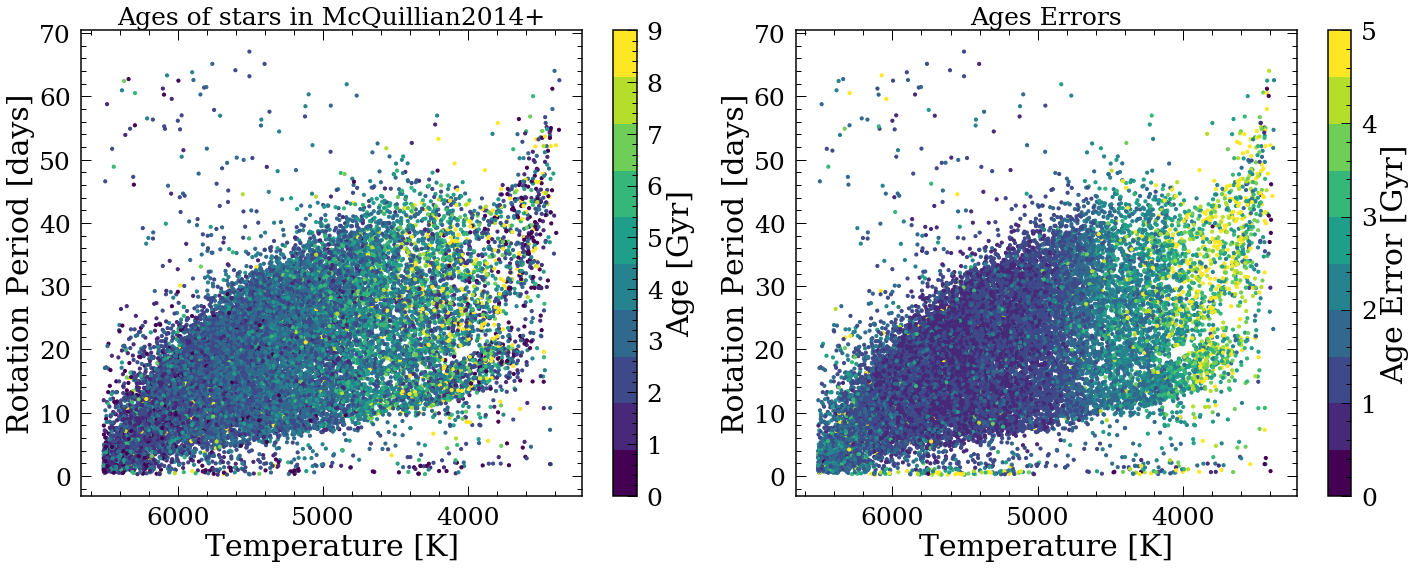

In [57]:
plt.figure(figsize=(20,8))
cm = plt.cm.get_cmap('viridis',10)
plt.subplot(1,2,1)
plt.scatter(df['teff_calc'],df['Prot'],c=df['kin_age'],s=10,vmin=0,vmax=9,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rotation Period [days]')

cb=plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('Ages of stars in McQuillian2014+',fontsize=25)

plt.subplot(1,2,2)
plt.scatter(df['teff_calc'],df['Prot'],c=df['kin_age_err_bs'],s=10,vmin=0,vmax=5,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rotation Period [days]')

cb=plt.colorbar()
cb.set_label('Age Error [Gyr]')
plt.title('Ages Errors',fontsize=25)
plt.tight_layout()




In [59]:
df.to_pickle('minchisq.pkl')

(array([ 4.,  2.,  6.,  6., 12.,  6.,  7.,  4.,  0.,  3.]),
 array([0.70389003, 1.02902854, 1.35416705, 1.67930556, 2.00444407,
        2.32958258, 2.65472109, 2.9798596 , 3.30499811, 3.63013663,
        3.95527514]),
 <a list of 10 Patch objects>)

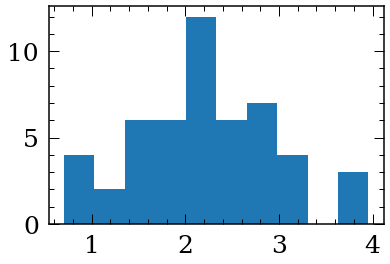

In [63]:
plt.hist(ages[50,:])